In [131]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io
import copy

from pywt import dwt2
from numpy import linalg as LA

In [132]:
cwd = os.getcwd()
X_train = scipy.io.loadmat('CP4_training_images.mat')['training_images']
Y_train = scipy.io.loadmat('CP4_training_labels.mat')['training_labels']

In [133]:
X_train = X_train.reshape((784,30000))
print(X_train.shape,Y_train.shape)

(784, 30000) (30000, 1)


In [134]:
def dc_wavelet(data):
    m, n = data.shape
    pxl = int(np.sqrt(m))
    nw = m // 4 
    dcData = np.zeros((nw,n))
    
    for k in range(n):
        X = data[:, k].reshape((pxl, pxl)).astype(float)
        coeffs = dwt2(X, 'haar')
        cH = coeffs[1][0]
        cV = coeffs[1][1]
        cod_cH1 = rescale(np.abs(cH))
        cod_cV1 = rescale(np.abs(cV))
        cod_edge = cod_cH1 + cod_cV1
        dcData[:, k] = cod_edge.reshape((nw,))
        
    return dcData

def rescale(x):
    # Rescale the input x to [0, 1]
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [135]:
dcData = dc_wavelet(X_train)
U, S, Vh = LA.svd(dcData, full_matrices=False)
features = 15
A1 = np.array([[features]])

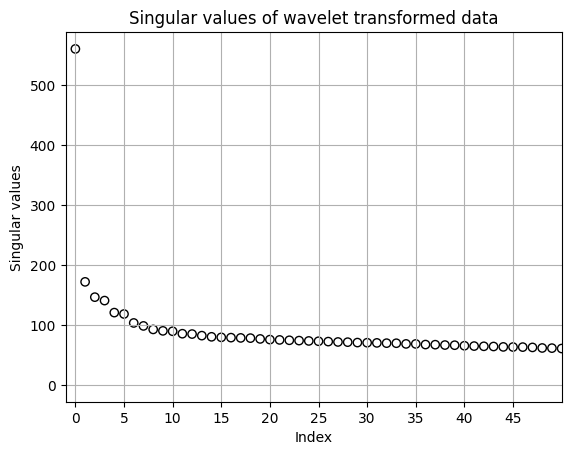

In [154]:
# plt.scatter(range(len(S)),S,facecolors='none',edgecolors='k')
# plt.grid()
# plt.xlim((-1,50))
# plt.xlabel('Index')
# plt.ylabel('Singular values')
# plt.title('Singular values of wavelet transformed data')
# plt.xticks(np.arange(0, 50, step=5))
# #plt.savefig('SV.png',dpi = 600)
# plt.show()

In [155]:
U = U[:,0:features]
A2 = copy.copy(U)

In [156]:
Img = U.T@dcData

In [157]:
X_train_0 = Img.T[Y_train.T[0]==0].T
X_train_1 = Img.T[Y_train.T[0]==1].T

In [158]:
X_train_0.shape

(15, 2932)

In [159]:
def SwSb(X_digit, X_other):
    # Compute the mean vectors for each class
    mean_class_0 = np.mean(X_digit, axis=1).reshape(-1, 1)
    mean_class_1 = np.mean(X_other, axis=1).reshape(-1, 1)
    # Compute the scatter matrices for each class
    within_class_var = np.zeros((X_digit.shape[0],X_digit.shape[0]))
    #scatter_class_0 = np.zeros((X_train.shape[0], X_train.shape[0]))
    #scatter_class_1 = np.zeros((X_train.shape[0], X_train.shape[0]))

    for i in range(X_digit.shape[1]):
        sample_0 = X_digit[:, i].reshape(-1,1)
        diff_0 = sample_0 - mean_class_0
        within_class_var += np.dot(diff_0, diff_0.T)

    for i in range(X_other.shape[1]):
        sample_1 = X_other[:, i].reshape(-1,1)
        diff_1 = sample_1 - mean_class_1
        within_class_var += np.dot(diff_1, diff_1.T)

    # Compute the within-class variance
    #within_class_var = scatter_class_0 + scatter_class_1
    # Compute the between-class variance
    diff_means = mean_class_0 - mean_class_1
    between_class_var = np.dot(diff_means, diff_means.T)
    
    return within_class_var, between_class_var

In [160]:
Sw, Sb = SwSb(X_train_0, X_train_1)
A3 = copy.copy(Sw)
A4 = copy.copy(Sb)

In [161]:
D, V2 = scipy.linalg.eig(Sb, Sw)
ind = np.argmax(np.abs(D))
w = V2[:, ind]
w /= np.linalg.norm(w, 2)

In [162]:
A5 = copy.copy(w.reshape(15,1))

In [163]:
v0 = w@X_train_0
v1 = w@X_train_1

In [164]:
if np.mean(v0) > np.mean(v1):
    w = -w
    v0 = -v0
    v1 = -v1

In [253]:
print(len(v0),len(v1))

2932 3438


In [254]:
2932+3438

6370

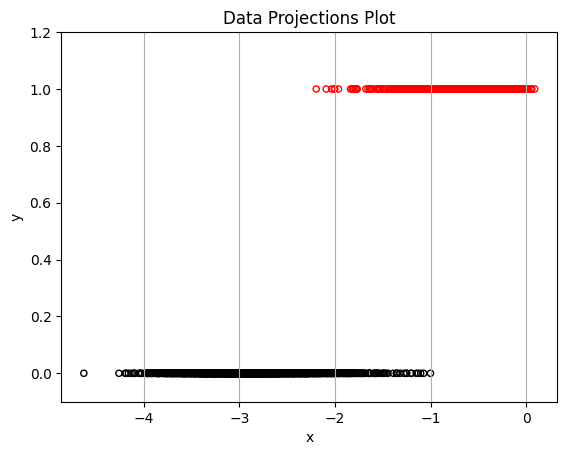

In [239]:
# plt.scatter(v0, np.zeros(len(v0)),s=20, facecolors='none',edgecolors='k')
# plt.scatter(v1, np.ones(len(v1)),s=20, facecolors='none',edgecolors='r')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Data Projections Plot')
# plt.ylim([-0.1, 1.2])
# plt.grid(axis='x')
# plt.savefig('proj.png',dpi=600)
# plt.show()

In [165]:
sort0 = sorted(v0)
sort1 = sorted(v1)

t1 = len(sort0)
t2 = 0
while sort0[t1-1] > sort1[t2]:
    t1 -= 1
    t2 += 1
    
threshold = (sort0[t1]+ sort1[t2])/2

In [255]:
threshold

-1.5481412069599552

In [166]:
A6 = np.array([[threshold]])

In [276]:
X_test = scipy.io.loadmat('CP4_test_images.mat')['test_images']
Y_test = scipy.io.loadmat('CP4_test_labels.mat')['test_labels']

In [277]:
X_test = X_test.reshape((784,5000))
print(X_test.shape,Y_test.shape)

(784, 5000) (5000, 1)


In [169]:
X_test = X_test.T[(Y_test.T[0]==0) | (Y_test.T[0]==1)].T

In [170]:
Y_test = Y_test.T[0][(Y_test.T[0]==0) | (Y_test.T[0]==1)].T

In [256]:
len(X_test)

784

In [281]:
1062-562

500

In [280]:
len(Y_test[Y_test.T[0]==1])

562

In [171]:
dcData_test = dc_wavelet(X_test)
TestMat = U.T@dcData_test
proj = w@TestMat

In [173]:
ResVec = []
for i in proj:
    if i > threshold:
        ResVec= np.append(ResVec,1)
    else:
        ResVec= np.append(ResVec,0)

In [174]:
A7 = copy.copy(ResVec.reshape(1,1062))

In [176]:
errNum = np.sum(np.abs(ResVec - Y_test))

In [177]:
1 - errNum/len(ResVec)

0.9971751412429378

In [23]:
accuracy = {}
for digit in range(10):
    X_train_digit = Img.T[Y_train.T[0]==digit].T
    X_train_other = Img.T[Y_train.T[0]!=digit].T
    
    Sw, Sb = SwSb(X_train_digit, X_train_other)
    
    D, V2 = scipy.linalg.eig(Sb, Sw)
    ind = np.argmax(np.abs(D))
    w = V2[:, ind]
    w /= np.linalg.norm(w, 2)
    
    v0 = w@X_train_digit
    v1 = w@X_train_other
    
    if np.mean(v0) > np.mean(v1):
        w = -w
        v0 = -v0
        v1 = -v1
    
    sort0 = sorted(v0)
    sort1 = sorted(v1)

    t1 = len(sort0)
    t2 = 0
    while sort0[t1-1] > sort1[t2]:
        t1 -= 1
        t2 += 1
    
    threshold = (sort0[t1]+ sort1[t2])/2
    
    dcData_test = dc_wavelet(X_test)
    TestMat = U.T@dcData_test
    proj = w@TestMat
    
    ResVec = []

    for i in proj:
        if i > threshold:
            ResVec= np.append(ResVec,None)
        else:
            ResVec= np.append(ResVec,digit)
    count = 0       
    for res in range(len(ResVec)):
        if ResVec[res]!=None:
            if ResVec[res]==Y_test.T[0][res]:
                count += 1 
        else:
            if Y_test.T[0][res]!=digit:
                count += 1 
    
    accuracy[digit] = count/len(ResVec) 

In [282]:
accuracy

{0: 0.958,
 1: 0.9792,
 2: 0.9336,
 3: 0.9212,
 4: 0.9128,
 5: 0.9148,
 6: 0.9578,
 7: 0.9616,
 8: 0.9312,
 9: 0.9274}

In [250]:
np.array(list(accuracy.values())).mean()

0.93976

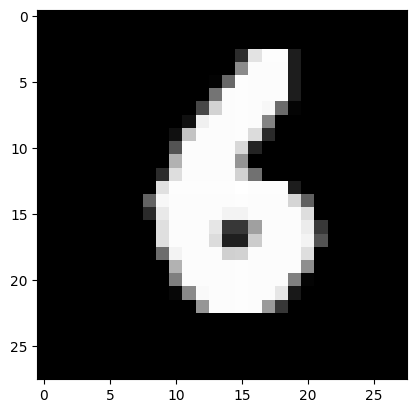

In [243]:
plt.imshow(X_train[:,4].reshape((28,28)),cmap='gray')
plt.savefig('example.png')
plt.show()

In [60]:
from sklearn import svm, metrics

In [115]:
X_train = scipy.io.loadmat('CP4_training_images.mat')['training_images'].reshape(784,30000).T
Y_train = scipy.io.loadmat('CP4_training_labels.mat')['training_labels'].T[0]

X_test = scipy.io.loadmat('CP4_test_images.mat')['test_images'].reshape(784,5000).T
Y_test = scipy.io.loadmat('CP4_test_labels.mat')['test_labels'].T[0]

In [129]:
clf = svm.SVC()
clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, predicted)}\n"
)

Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.99      0.99      0.99       562
           2       0.97      0.98      0.97       508
           3       0.96      0.98      0.97       501
           4       0.98      0.98      0.98       474
           5       0.98      0.98      0.98       455
           6       0.99      0.99      0.99       481
           7       0.97      0.96      0.97       505
           8       0.97      0.97      0.97       489
           9       0.97      0.96      0.97       525

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000




In [126]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'gini') 
dt.fit(X_train , Y_train)
predicted = dt.predict(X_test)
print(
    f"Classification report for classifier {dt}:\n"
    f"{metrics.classification_report(Y_test, predicted)}\n"
)

Classification report for classifier DecisionTreeClassifier():
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       500
           1       0.93      0.97      0.95       562
           2       0.85      0.84      0.85       508
           3       0.79      0.78      0.78       501
           4       0.83      0.87      0.85       474
           5       0.79      0.79      0.79       455
           6       0.88      0.87      0.87       481
           7       0.88      0.88      0.88       505
           8       0.83      0.80      0.81       489
           9       0.83      0.81      0.82       525

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000




In [121]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(286,), activation='logistic', alpha=1e-5,
                    solver='sgd', tol=1e-8, random_state=1,
                    learning_rate_init=.01, verbose=True)

mlp.fit(X_train,Y_train)
predicted = mlp.predict(X_test)

print(
    f"Classification report for classifier {mlp}:\n"
    f"{metrics.classification_report(Y_test, predicted)}\n"
)

Iteration 1, loss = 0.63645384
Iteration 2, loss = 0.32500774
Iteration 3, loss = 0.28489449
Iteration 4, loss = 0.26232141
Iteration 5, loss = 0.24062093
Iteration 6, loss = 0.22859995
Iteration 7, loss = 0.22594480
Iteration 8, loss = 0.22301433
Iteration 9, loss = 0.20609116
Iteration 10, loss = 0.20082972
Iteration 11, loss = 0.19718505
Iteration 12, loss = 0.19771098
Iteration 13, loss = 0.18307342
Iteration 14, loss = 0.18398788
Iteration 15, loss = 0.17626216
Iteration 16, loss = 0.17107270
Iteration 17, loss = 0.17438300
Iteration 18, loss = 0.16756958
Iteration 19, loss = 0.16806131
Iteration 20, loss = 0.16403047
Iteration 21, loss = 0.16270960
Iteration 22, loss = 0.15461776
Iteration 23, loss = 0.15356633
Iteration 24, loss = 0.14937546
Iteration 25, loss = 0.14958884
Iteration 26, loss = 0.14311717
Iteration 27, loss = 0.14496637
Iteration 28, loss = 0.13860192
Iteration 29, loss = 0.14187312
Iteration 30, loss = 0.14631676
Iteration 31, loss = 0.14242770
Iteration 32, los